In [1]:
# general
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
# graphing
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
# tokenization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from nltk.corpus import stopwords
import nltk
import nltk.stem

In [4]:
sid = SentimentIntensityAnalyzer()

In [5]:
## define a function for word-cloud
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

def word_cloud(data, col: str):
    # term frenquency word cloud
    long_string = ','.join(list(data[col].values))

    wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=250, collocations=False).generate(long_string)
    # set the word color to black
    wordcloud.recolor(color_func = black_color_func)
    # set the figsize
    plt.figure(figsize=[15,10])
    # plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")
    # remove plot axes
    plt.axis("off")

def word_cloudFreq(d: dict, maxword):
    wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=maxword, collocations=False).generate_from_frequencies(d)
    # set the word color to black
    wordcloud.recolor(color_func = black_color_func)
    # set the figsize
    plt.figure(figsize=[15,10])
    # plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")
    # remove plot axes
    plt.axis("off")

    

In [6]:
english_stemmer = nltk.stem.SnowballStemmer('english')

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

In [7]:
# importing data
dfReviewNew = pd.read_csv('/Users/zejiachen/Desktop/fall 2021/Voice of Customer/sampleData/reviewSample.csv')
mostPosReviews = pd.read_csv('/Users/zejiachen/Desktop/fall 2021/Voice of Customer/sampleData/mostPosReview.csv')
mostNegReviews = pd.read_csv('/Users/zejiachen/Desktop/fall 2021/Voice of Customer/sampleData/mostNegReview.csv')

In [8]:
print(dfReviewNew.shape)
print(mostPosReviews.shape)
print(mostNegReviews.shape)

(35001, 7)
(18843, 11)
(642, 11)


In [9]:
# convert selected column to String
dfReviewNew[['reviewerID', 'asin', 'reviewText','summary']] = dfReviewNew[['reviewerID', 'asin', 'reviewText','summary']].astype(str)


---
<b>Review DTM</b>

In [10]:
cvs = StemmedCountVectorizer(min_df=3, analyzer="word", stop_words='english')

# generates document-term matrix for all the docs
dtmReview = cvs.fit_transform(dfReviewNew['reviewText'])

# check the shape
print(dtmReview.shape)

# get feature name with stemmed words removed
features_stemRemoved = cvs.get_feature_names()

(35001, 7336)


In [11]:
reviewVec = pd.DataFrame(data=dtmReview.toarray(),columns=features_stemRemoved)
reviewVecDF = pd.DataFrame(dfReviewNew['reviewTime'], columns = ['reviewTime'])

<b>Bigram DTM</b>

In [12]:
cvs2 = StemmedCountVectorizer(min_df=3, analyzer="word", stop_words='english', ngram_range = (2, 2))

# generates document-term matrix for all the docs
dtmReviewBi = cvs2.fit_transform(dfReviewNew['reviewText'])

# check the shape
print(dtmReviewBi.shape)

# get feature name with stemmed words removed
features_Bigram = cvs2.get_feature_names()


(35001, 41754)


In [13]:
reviewVecBi = pd.DataFrame(data=dtmReviewBi.toarray(),columns=features_Bigram)
reviewVecBiDF = pd.DataFrame(dfReviewNew['reviewTime'], columns = ['reviewTime'])
reviewVecBiDF['total'] = list(reviewVecBi.sum(axis=1))

reviewVecBiDF.head()

,reviewTime,total
0,2013-10-06,4
1,2013-08-09,17
2,2016-04-05,4
3,2016-02-13,13
4,2015-12-10,0


---
### Most Neg/Pos Review

In [14]:
# customize the stop words
my_additional_stop_words = ['num', 'just', 'number', 'play']
stopWords = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [15]:
cvs_neg = StemmedCountVectorizer(min_df=3, analyzer="word", stop_words=stopWords)

# generates document-term matrix for all the docs
dtmNegReview = cvs_neg.fit_transform(mostNegReviews['reviewText'])

# check the shape
print(dtmNegReview.shape)

# get feature name with stemmed words removed
features_negReview = cvs_neg.get_feature_names()

(642, 1065)


In [16]:
## check n-gram
bigram_cvNeg = StemmedCountVectorizer(min_df=3, analyzer="word", stop_words=stopWords, ngram_range=(2, 2))
dtmBigramNeg=bigram_cvNeg.fit_transform(mostNegReviews['reviewText'])

# check the shape
print(dtmBigramNeg.shape)

# get feature name with stemmed words removed
features_negReview_bigram = bigram_cvNeg.get_feature_names()


(642, 243)


In [17]:
# here's our number of features
num_negFeats = dtmNegReview.shape[1] # using the doc-term matrix from up above w/ the stopwords

# here's a dictionary to store the features and counts key/value pairs
negFeature_dict = {}

for x in range(num_negFeats):      # iterate over the number of features
    key = cvs_neg.get_feature_names()[x]  # get the feature name at position [x]
                                              # note that we're using the stopwords cv object
    value = dtmNegReview.toarray().sum(axis=0)[x]  # sum the counts of the feature at position [x] for all documents
    
    negFeature_dict[key] = value # add the new key/value pair to the dictionary
    
# then sort the dictionary in order of counts
sortFeats = sorted(negFeature_dict.items(), key=lambda x: x[1], reverse=True)


In [18]:
negFeatureRefine = []
negFeature_list = list(negFeature_dict.keys())

for i in range(len(negFeature_list)):
    scores = sid.polarity_scores(negFeature_list[i])
    if scores['compound'] < 0:
        negFeatureRefine.append(negFeature_list[i])

In [19]:
print(len(negFeatureRefine))
negFeatureRefine[:10]

92


['accident',
 'annoy',
 'awkward',
 'bad',
 'block',
 'bore',
 'bother',
 'broke',
 'broken',
 'bummer']

In [59]:
negFeature_dictRefine = {}

for i in negFeatureRefine:
    negFeature_dictRefine[i] = negFeature_dict[i]

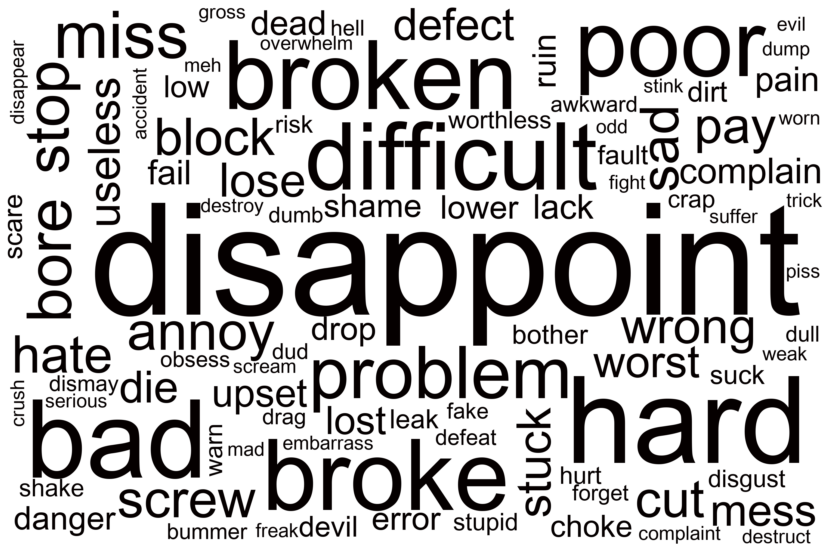

In [270]:
word_cloudFreq(negFeature_dictRefine, 2)

In [20]:
# here's our number of features
num_negBigramFeats = dtmBigramNeg.shape[1] # using the doc-term matrix from up above w/ the stopwords

# here's a dictionary to store the features and counts key/value pairs
negBigramFeature_dict = {}

for x in range(num_negBigramFeats):      # iterate over the number of features
    key = bigram_cvNeg.get_feature_names()[x]  # get the feature name at position [x]
                                              # note that we're using the stopwords cv object
    value = dtmBigramNeg.toarray().sum(axis=0)[x]  # sum the counts of the feature at position [x] for all documents
    
    negBigramFeature_dict[key] = value # add the new key/value pair to the dictionary
    
# then sort the dictionary in order of counts
sortNegBigramFeats = sorted(negBigramFeature_dict.items(), key=lambda x: x[1], reverse=True)


In [21]:
negFeatureBigramRefine = []
negFeaturBigram_list = list(negBigramFeature_dict.keys())

for i in range(len(negFeaturBigram_list)):
    scores = sid.polarity_scores(negFeaturBigram_list[i])
    if scores['compound'] < 0:
        negFeatureBigramRefine.append(negFeaturBigram_list[i])

In [22]:
print(len(negFeatureBigramRefine))
negFeatureBigramRefine[:10]

42


['bad design',
 'bad qual',
 'bad th',
 'big disappoint',
 'bored quick',
 'box crush',
 'broke day',
 'broke month',
 'choking hazard',
 'crayons broken']

In [64]:
negFeatureBi_dictRefine = {}

for i in negFeatureBigramRefine:
    negFeatureBi_dictRefine[i] = negBigramFeature_dict[i]

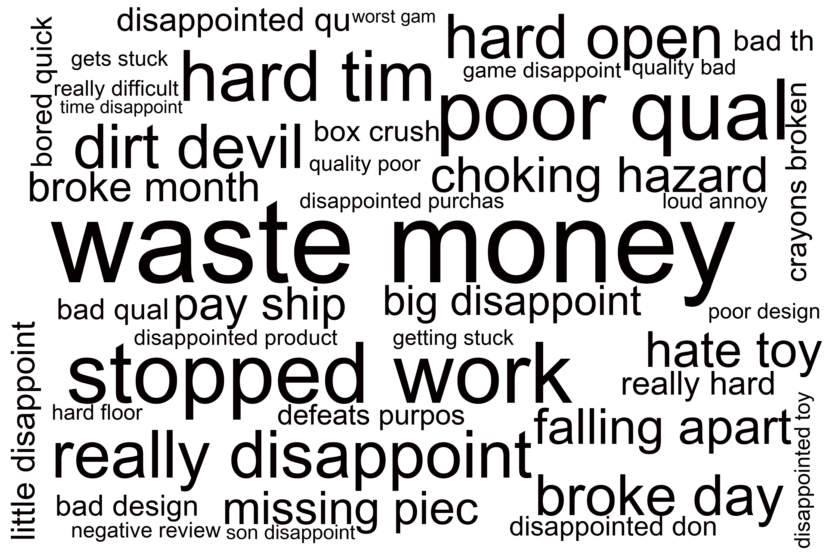

In [271]:
word_cloudFreq(negFeatureBi_dictRefine, 200)

### Plotting TimeSeries Graph for Bad words

In [257]:
negReviewVecDF = reviewVecDF.copy()
negReviewVecDF["reviewTime"] = pd.to_datetime(negReviewVecDF["reviewTime"])
negReviewVecDF["year"] = pd.DatetimeIndex(negReviewVecDF['reviewTime']).year
negReviewVecDF["year"] = pd.to_datetime(negReviewVecDF["year"], format='%Y')
negReviewVecDF['badwords'] = list(reviewVec[negFeatureRefine].sum(axis=1))
negReviewVecDF['total'] = list(reviewVec.sum(axis=1))

In [258]:
negReviewVecDFGroupBy = pd.DataFrame(negReviewVecDF.groupby(['year'])[['badwords', 'total']].apply(sum))
negReviewVecDFGroupBy['%'] = round(negReviewVecDFGroupBy.badwords / negReviewVecDFGroupBy.total, 5) * 100
negReviewVecDFGroupBy.head()

,badwords,total,%
year,,,
1999-01-01,1,80,1.250
2000-01-01,45,2336,1.926
2001-01-01,190,7600,2.500
2002-01-01,247,10581,2.334
2003-01-01,239,11347,2.106


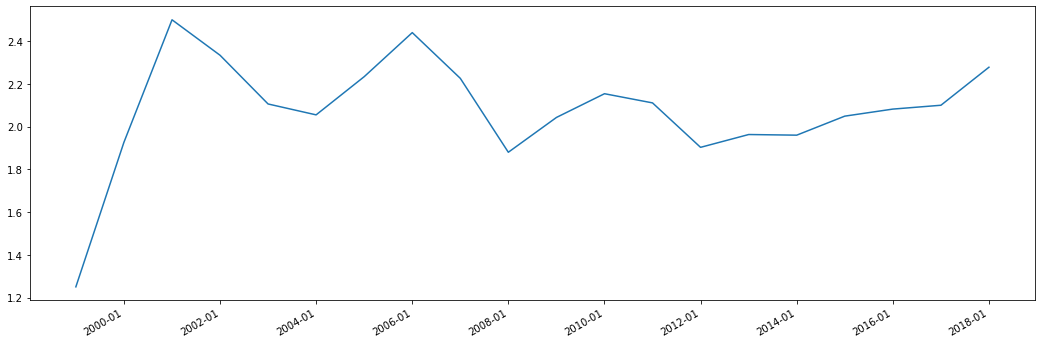

In [260]:
fig, ax = plt.subplots(figsize=(18, 6))

half_year_locator = mdates.MonthLocator(interval=6)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month

ax.xaxis.set_major_formatter(year_month_formatter)

ax.plot(negReviewVecDFGroupBy['%']);

# Rotates and right aligns the x labels. 
# Also moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()

### Plotting TimeSeries Graph for Good words

In [26]:
cvs_pos = StemmedCountVectorizer(min_df=3, analyzer="word", stop_words=stopWords)

# generates document-term matrix for all the docs
dtmPosReview = cvs_pos.fit_transform(mostPosReviews['reviewText'])

# check the shape
print(dtmPosReview.shape)

# get feature name with stemmed words removed
features_PosReview = cvs_pos.get_feature_names()

(18843, 6199)


check n-gram for more context

In [27]:
bigram_cvPos = StemmedCountVectorizer(min_df=3, analyzer="word", stop_words=stopWords, ngram_range=(2, 2))
dtmBigramPos=bigram_cvPos.fit_transform(mostPosReviews['reviewText'])

# check the shape
print(dtmBigramPos.shape)

# get feature name with stemmed words removed
features_posReview_bigram = bigram_cvPos.get_feature_names()


(18843, 28205)


**Positive Words Frequency**

In [28]:
posreviewVec = pd.DataFrame(data=dtmPosReview.toarray(),columns=features_PosReview)

posFeatureRefine = []

for i in range(len(features_PosReview)):
    scores = sid.polarity_scores(features_PosReview[i])
    if scores['compound'] > 0.3:
        posFeatureRefine.append(features_PosReview[i])

In [29]:
posFeatureRefine_dict = {}

for x in range(len(posFeatureRefine)):
    key = posFeatureRefine[x]
    value = posreviewVec[key].sum()
    posFeatureRefine_dict[key] = value
    

In [215]:
len(posFeatureRefine_dict)

197

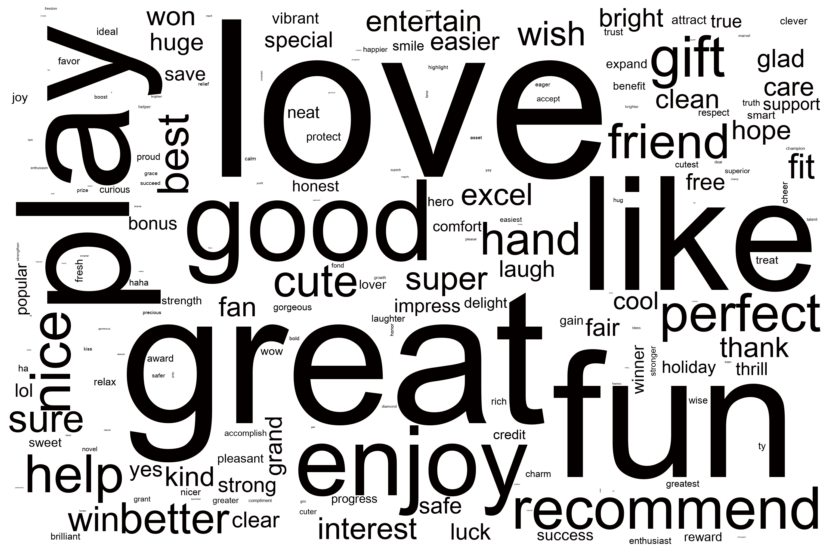

In [272]:
word_cloudFreq(posFeatureRefine_dict, 200)

**Positive Words(Bigram) Frequency**

In [30]:
posreviewBiVec = pd.DataFrame(data=dtmBigramPos.toarray(),columns=features_posReview_bigram)

posFeatureBiRefine = []

for i in range(len(features_posReview_bigram)):
    scores = sid.polarity_scores(features_posReview_bigram[i])
    if scores['compound'] > 0.7:
        posFeatureBiRefine.append(features_posReview_bigram[i])

In [31]:
len(posFeatureBiRefine)

339

In [219]:
posFeatureRefineBi_dict = {}

for x in range(len(posFeatureBiRefine)):
    key = posFeatureBiRefine[x]
    value = posreviewBiVec[key].sum()
    posFeatureRefineBi_dict[key] = value
    

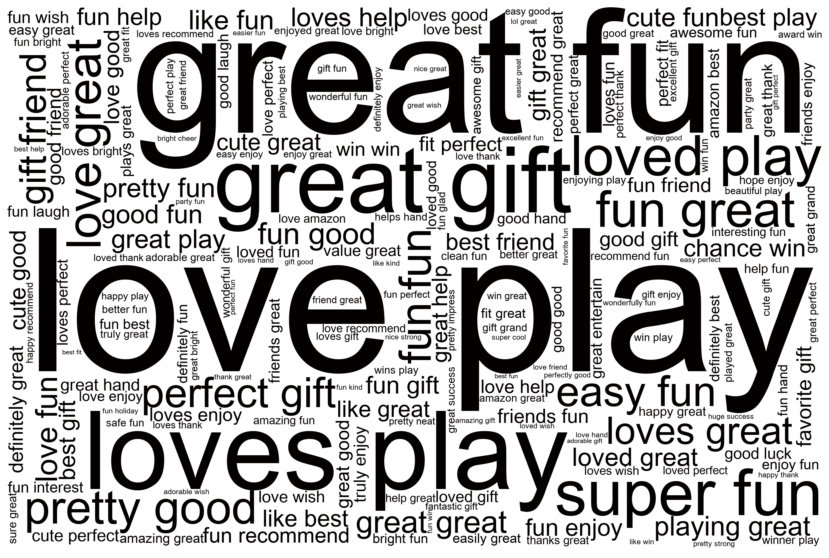

In [273]:
word_cloudFreq(posFeatureRefineBi_dict, 200)

### Plotting TimeSeries Graph for Good words

In [254]:
posReviewVecDF = reviewVecDF.copy()
posReviewVecDF["reviewTime"] = pd.to_datetime(posReviewVecDF["reviewTime"])
posReviewVecDF["year"] = pd.DatetimeIndex(posReviewVecDF['reviewTime']).year
posReviewVecDF["year"] = pd.to_datetime(posReviewVecDF["year"], format='%Y')
posReviewVecDF['goodwords'] = list(reviewVec[posFeatureRefine].sum(axis=1))
posReviewVecDF['total'] = list(reviewVec.sum(axis=1))

In [267]:
posReviewVecDFGroupBy = pd.DataFrame(posReviewVecDF.groupby(['year'])[['goodwords', 'total']].apply(sum))
posReviewVecDFGroupBy['%'] = round(posReviewVecDFGroupBy.goodwords / posReviewVecDFGroupBy.total, 5) * 100
posReviewVecDFGroupBy.head()

,goodwords,total,%
year,,,
1999-01-01,11,80,13.750
2000-01-01,289,2336,12.372
2001-01-01,874,7600,11.500
2002-01-01,1255,10581,11.861
2003-01-01,1243,11347,10.954


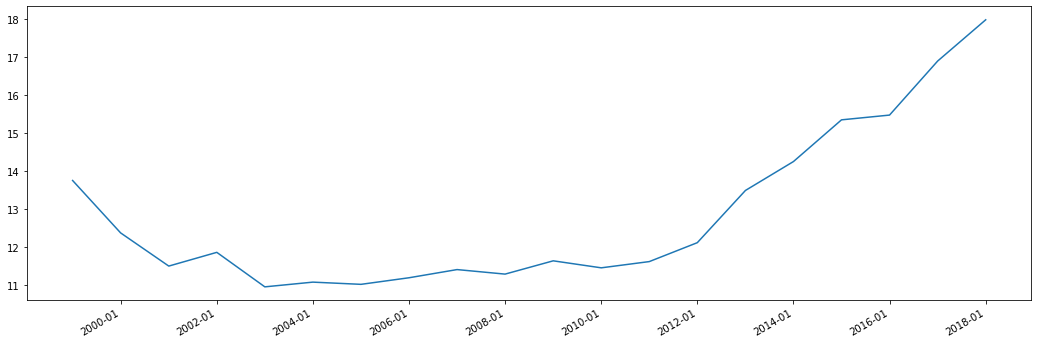

In [268]:
fig, ax = plt.subplots(figsize=(18, 6))

half_year_locator = mdates.MonthLocator(interval=6)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month

ax.xaxis.set_major_formatter(year_month_formatter)

ax.plot(posReviewVecDFGroupBy['%']);

# Rotates and right aligns the x labels. 
# Also moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()

---
## Store the bad/good words

In [32]:

with open("negFeatureRefine.txt", "w") as f:
    for s in negFeatureRefine:
        f.write(str(s) +"\n")
        
with open("negFeatureBigramRefine.txt", "w") as f:
    for s in negFeatureBigramRefine:
        f.write(str(s) +"\n")
        
with open("posFeatureRefine.txt", "w") as f:
    for s in posFeatureRefine:
        f.write(str(s) +"\n")

with open("posFeatureBiRefine.txt", "w") as f:
    for s in posFeatureBiRefine:
        f.write(str(s) +"\n")
        